# Exercise 5.2 - Solution
## Interpolation
In this task, we implement a simple NN to learn a complicated function.

In [2]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

layers = keras.layers

### Generation of data

In [2]:
def some_complicated_function(x):
    return (
        (np.abs(x)) ** 0.5
        + 0.1 * x
        + 0.01 * x ** 2
        + 1
        - np.sin(x)
        + 0.5 * np.exp(x / 10.0)
        ) / (0.5 + np.abs(np.cos(x)))

Let's simulate the train data

In [3]:
N_train = 10 ** 4  # number of training samples
# Note: "[:, np.newaxis]" reshapes array to (N,1) as required by our DNN (we input one feature per sample)
xtrain = np.random.uniform(-10, 10, N_train)[:, np.newaxis]
ytrain = some_complicated_function(xtrain) + np.random.randn(xtrain.shape[0])  # train data includes some noise

In [4]:
print("xtrain.shape", xtrain.shape)
print("ytrain.shape", ytrain.shape)

xtrain.shape (10000, 1)
ytrain.shape (10000, 10000)


Simulate test data

In [5]:
N_test = 10000  # number of testing samples
xtest = np.linspace(-10, 10, N_test)
ytest = some_complicated_function(xtest)

In [6]:
print("xtest.shape", xtest.shape)
print("ytest.shape", ytest.shape)

xtest.shape (10000,)
ytest.shape (10000,)


### Define Model

In this case, we make use of a simple network with 5 layers. As activation function the ReLU is used. We further add parameter norm penalties (L1 and L2) as regularization strategy.

In [7]:
nb_nodes = 32
nb_layers = 4
activation = "relu"
reg_strategy = keras.regularizers.l1_l2(l1=0.01, l2=0.01)  # use L1 and L2 regularization

model = keras.models.Sequential(name="1Dfit")
model.add(layers.Dense(nb_nodes, activation=activation, kernel_regularizer=reg_strategy,
                       input_dim=xtrain.shape[1]))

for i in range(nb_layers - 1):
    model.add(layers.Dense(nb_nodes, activation=activation, kernel_regularizer=reg_strategy))

model.add(layers.Dense(1))

print(model.summary())

Model: "1Dfit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
None


### Compile the model (set an objective and choose an optimizer)

In [8]:
adam = keras.optimizers.Adam(lr=0.001)  # learning rate = 0.001
model.compile(loss="MeanSquaredError", optimizer=adam)

### Train the model

In [9]:
epochs = 100
save_period = 20  # after how many epochs the model should be saved?

chkpnt_saver = keras.callbacks.ModelCheckpoint("weights-{epoch:02d}.hdf5", save_weights_only=True, save_freq=save_period)

results = model.fit(
    xtrain,
    ytrain,
    batch_size=64,
    epochs=epochs,
    verbose=1,
    callbacks=[chkpnt_saver]
    )

Epoch 1/100
157/157 [==============================] - 1s 5ms/step - loss: 15.2431
Epoch 2/100
157/157 [==============================] - 1s 5ms/step - loss: 6.8571
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 5.8455
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 5.3997
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 5.0038
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 4.6660
Epoch 7/100
157/157 [==============================] - 1s 5ms/step - loss: 4.5469
Epoch 8/100
157/157 [==============================] - 1s 4ms/step - loss: 4.3841
Epoch 9/100
157/157 [==============================] - 1s 4ms/step - loss: 4.2089
Epoch 10/100
157/157 [==============================] - 1s 4ms/step - loss: 4.0169
Epoch 11/100
157/157 [==============================] - 1s 4ms/step - loss: 3.9143
Epoch 12/100
157/157 [==============================] - 1s 4ms/step - loss: 3.7840
Epoch 13/100

Compare the performance of the model during the training.

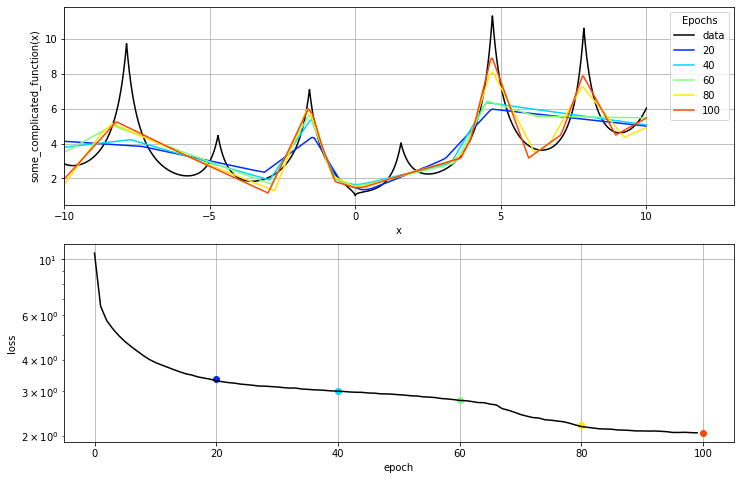

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

ax1.plot(xtest, ytest, color="black", label="data")
saved_epochs = range(save_period, epochs + 1, save_period)

colors = [plt.cm.jet((i + 1) / float(len(saved_epochs) + 1)) for i in range(len(saved_epochs))]

for i, epoch in enumerate(saved_epochs):
    model.load_weights("weights-{epoch:02d}.hdf5".format(epoch=epoch))
    ypredict = model.predict(xtest).squeeze()
    ax1.plot(xtest.squeeze(), ypredict, color=colors[i], label=epoch)
    ax2.plot(epoch, results.history["loss"][epoch - 1], color=colors[i], marker="o")

ax1.set(xlabel="x", ylabel="some_complicated_function(x)", xlim=(-10, 13), title="")
ax1.grid(True)
ax1.legend(loc="upper right", title="Epochs")

ax2.plot(results.history["loss"], color="black")
ax2.set(xlabel="epoch", ylabel="loss")
ax2.grid(True)
ax2.semilogy()

plt.show()

As can be seen, with an increasing number of iterations, the performance of the DNN improves.
Additionally, it can be seen nicely that the ReLU activation function was used (sharp linear intervals).